In [1]:
import os

import matplotlib.pyplot as plt

import librosa
import scipy
import scipy.signal as sig
import scipy.io.wavfile as scw

import numpy as np

import wave
import cmath as cm
import math

import default_settings


# preparation : define extract_feature.

In [2]:
def levinson(signal, order):
    x = signal
    p = order
    autocorr = np.correlate(x,x,mode='full')
    r = autocorr[len(x)-1:len(x)+p]

    a = np.zeros(p+1)
    k = np.zeros(p)
    a[0] = 1
    a[1] = -r[1] / r[0]
    k[0] = a[1]
    E = r[0] + r[1] * a[1]
    for q in range(1,p):
        k[q] = -np.sum(a[0:q+1] * r[q+1:0:-1]) / E
        U = a[0:q+2]
        V = U[::-1]
        a[0:q+2] = U + k[q] * V
        E *= 1-k[q] * k[q]

    return a, k


def preEmphasis(signal, p):
    """プリエンファシスフィルタ"""
    # 係数 (1.0, -p) のFIRフィルタを作成
    return sig.lfilter([1.0, -p], 1, signal)


def autocorr(x, nlags=None):
    """自己相関関数を求める
    x:     信号
    nlags: 自己相関関数のサイズ（lag=0からnlags-1まで）
           引数がなければ（lag=0からlen(x)-1まですべて）
    """
    N = len(x)
    if nlags == None: nlags = N
    r = np.zeros(nlags)
    for lag in range(nlags):
        for n in range(N - lag):
            r[lag] += x[n] * x[n + lag]
    return r

In [3]:
def FFT(x):
    N = x.shape[0]
    
    # Recursive processing end confirmation
    if N==1:
        return x[0]
    
    x_even = x[0:N:2]
    x_odd = x[1:N:2]
    
    # Recursive processing
    X_even = FFT(x_even)
    X_odd = FFT(x_odd)
    
    # weight
    W = []
    for t in range(N//2):
        W.append(np.exp(-1j * ((2*np.pi*t) / N)))
    W = np.array(W)
    
    X = np.zeros(N, dtype="complex")
    X[0:N//2] = X_even + W*X_odd
    X[N//2:N] = X_even - W*X_odd
    
    return X


def IFFT(X):
    N = X.shape[0]
    X = X.conjugate()
    x = FFT(X)
    return (1/N) * x.conjugate()


In [4]:
def extract_formant(x, fs, deg):
    a, k = levinson(x,deg)
    
    w, h = sig.freqz(1, a)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(fs * w / 2.0 / np.pi, 20 * np.log10(np.abs(h)))
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('$1 / |A(e^{j\omega})|$ [dB]')
    plt.show()
    
    poles = np.roots(a)
    intns = np.abs(poles)
    ff = np.angle(poles) * fs / 2.0 / np.pi
    formantfreq = ff[(ff > 10) & (ff < fs / 2.0 - 10) & (intns > 0.8)]

    print(formantfreq)
    return formantfreq

def extract_cepstrum(x, sr, deg):
    fft_data_ori = FFT(x)
    freq_ori = np.arange(len(fft_data_ori)) * sr / len(fft_data_ori)
    pow_spec = np.log10(np.real(np.abs(fft_data_ori)**2))
    cep = IFFT(pow_spec)
    return cep[:deg]

def extract_mfcc(x, sr, deg):
    if len(x) <= 2048:
        mfcc = librosa.feature.mfcc(y=x, sr=sr ,n_mfcc=deg, n_fft=len(x))
    else:
        mfcc = librosa.feature.mfcc(y=x, sr=sr ,n_mfcc=deg)
    return mfcc


speech_sample/A_a.wav


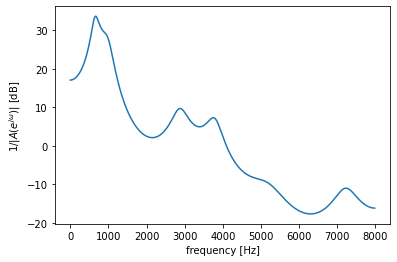

[7224.07497687 5193.71641059 3791.44784502 2872.82390869  988.20804392
  649.35692722]
[-0.70768141-0.00000000e+00j  0.6939591 -1.06902334e-16j
  0.15675354-1.35033992e-17j  0.05267697-3.06829215e-17j
  0.18167345+1.14058069e-16j  0.12798404+3.56702515e-17j
 -0.01132817-2.61839060e-16j -0.07129921+1.28647364e-16j
 -0.11887636+8.16404236e-17j -0.10342169-1.08637058e-16j
 -0.08694524+1.76458986e-16j -0.0738171 -1.18503297e-16j
 -0.04963763-1.37117694e-16j -0.02673921+1.73038667e-16j
 -0.11898161+2.29351111e-17j -0.09094993-2.48661768e-16j
  0.00555841+2.86771475e-16j  0.04515897-1.31080043e-16j
  0.01059303+1.32538633e-16j -0.05117417-4.87348877e-17j]
[[ -80.44891416  -96.45900121 -114.36119098  -85.2196553 ]
 [ 132.82625828  117.4180809    95.6794617   120.54662512]
 [ -14.65536916  -18.22398721  -29.92804018  -25.96895865]
 [  -2.18209271   -0.75077674   -4.59704634  -10.88592942]
 [ -85.02749488  -81.49743979  -77.5005075   -79.26763963]
 [   5.76359854    5.47188486    4.65210604    

In [5]:
speech_sample_dir = 'speech_sample'
wav_file = os.path.join(speech_sample_dir, 'A_a.wav')
print(wav_file)

sampling_rate, sample_data = scw.read(wav_file)
sample_data = sample_data / 32768
return_formant = extract_formant(sample_data, sampling_rate, 12)
return_cep = extract_cepstrum(sample_data[:512], sampling_rate, 20)
print(return_cep)
return_mfcc = extract_mfcc(sample_data, sampling_rate, 20)
print(return_mfcc)